# Proyecto 6:  Reconocimiento facial de mascarilla


## Dataset
Se utilizó un [dataset de Kaggle](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset) con alrededor de 12 000 imágenes con la siguiente estructura.

```
dataset
├── Train
│   ├── WithMask (50 000 imágenes)
│   └── WithoutMask (50 000 imágenes)
├── Test
│   ├── WithMask (483 imágenes)
│   └── WithoutMask (509 imágenes)
└── Validation
    ├── WithMask (400 imágenes)
    └── WithoutMask (400 imágenes)
```

## Workflow para entrenar la CNN y adaptarla al reconocimiento de mascarillas

### 1. Definir la  arquitectura de la red neuronal convolucional.
Se utilizó la misma arquitectura realizada en clase y se mantuvo ya que las métricas demostraron buenos resultados.

Se tienen dos capas de `Conv2D` que aplican el operador de convolución a la matriz input con un kernel de 3x3 y luego una capa de `MaxPooling2D` que reduce la matriz obteniendo el máximo valor de un área de interes de 2x2. Luego se utilizan capas de una arquitectura tradicional de red neuronal, primero convirtiendo la matriz a un array con `Flatten` y tres capas `Dense` (capas tradicionales de red neuronal) con 64, 20 y 2 neuronas. La última capa es la capa de salida que, con una activación `softmax` y dos neuronas, resulta en la probabilidad de que una imagen corresponda a cada valor de la variable clase (sin mascarilla 0 o con mascarilla 1).

```python
  # cnn.py: En CNN.build()
  self.model = Sequential([
      Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=self.X_train[0].shape),
      Conv2D(64, kernel_size=(3,3), activation='relu'),
      MaxPooling2D( pool_size=(2,2) ),

      Flatten(),
      Dense(64, activation='relu'),
      Dense(20, activation='relu'),
      Dense( len(self.classes), activation='softmax' )
    ])
```


### 2. Preprocesamiento del dataset. 
Se llevó a cabo un preprocesamiento en todas las imagenes del dataset. Este consiste en reducir su tamaño a una imagen de 50x50 píxeles, convertir en array con `tf.keras.preprocessing.image.img_to_array
` y binarizar los labels que acompañaban a las imágenes.

El código de preprocesamiento se encuentra en `load_dataset() y `binarize_labels()` en `utils.py`, funciones basadas en el código trabajado en clase.

```python
# utils.py

def load_dataset( img_dirs, preprocessors=[], verbose=1 ):
  # preprocessors es una lista de funciones que reciben y devuelven una matriz de imagen de OpenCV
  data = []
  labels = []
  for img_dir in img_dirs:
    img_paths = os.listdir(img_dir)

    for i, img_path in enumerate( img_paths ):
      if img_path == ".DS_Store": continue
      img_path = f"{img_dir}/{img_path}"
      img = cv2.imread( img_path )
      label = img_path.split(os.path.sep)[-2]
      for p in preprocessors:
        img = p(img)
      data.append( img )    
      labels.append( label )
      if verbose>0 and i>0 and (i+1)%verbose==0:
        print( f"Preprocessing {label} {i+1}/{len(img_paths)}" )
  return np.array(data), labels

def binarize_labels(labels, classes):
  bin_labels = []
  for l in labels:
    vec = [0]*len(classes)
    vec[classes.index(l)] = 1
    bin_labels.append(vec)
  return np.array(bin_labels)
```

La llamada a estas funciones se realiza en `CNN.preprocess()`, llamada en el constructor, antes de entrenar a la CNN.

```python
# cnn.py: CNN.preprocess()
  def preprocess(self, train_dirs, test_dirs, preprocessfile):
    # train_dirs y test_dirs son los directorios que incluyen las imagenes de entrenamiento y para testeo
    # preprocessfile es el nombre de un archivo binario con las imágenes preprocesadas. Si el archivo existe, se evita preprocesar nuevamente la data y si no existe, se crea.
    print("[IN PROGRESS] Preprocessing data")

    if preprocessfile is not None:
      with open(preprocessfile, "rb") as f:
        self.X_train, self.X_test, self.Y_train, self.Y_test, self.classes = pickle.load(f)
      return

    print("[IN PROGRESS] Preprocessing train data")
    X_train, labels = utils.load_dataset(train_dirs,
                    [utils.resize(50,50), img_to_array],
                    verbose=1000
                  )
    self.X_train = X_train.astype( "float" )/255.0
    self.classes = list(set(labels))
    self.Y_train = utils.binarize_labels(labels, self.classes)
    print("[DONE] Preprocess train data")

    print("[IN PROGRESS] Preprocessing test data")
    X_test, labels = utils.load_dataset(train_dirs,
                    [utils.resize(50,50), img_to_array],
                    verbose=1000
                  )
    self.X_test = X_test.astype( "float" )/255.0
    self.classes = list(set(labels))
    self.Y_test = utils.binarize_labels(labels, self.classes)
    print("[DONE] Preprocess test data")

    with open("preprocess.pickle", "wb") as f:
      pickle.dump([self.X_train, self.X_test, self.Y_train, self.Y_test, self.classes], f)

    print("[DONE] Preprocess data")
    
```

### 3. Definir los parámetros para el entrenamiento y entrenar
Para empezar, al construir el modelo, se compiló con los siguientes parámetros para medir el desempeño del modelo.

* Cross entropy como medida de loss
* Una gradiente con un grado de aprendizaje de 0.05
* Accuracy como medida de desempeño

```python
# cnn.py: CNN.build()
self.model.compile( loss='categorical_crossentropy', optimizer=SGD(lr=0.05), metrics = ['accuracy'] )
```

Los siguientes párametros y detalles fueron considerados para el entrenamiento para la CNN:

* Epochs: 10
* Tamaño de las imágenes: Redimensionadas a 50x50px
* Data de entrenamiento: 10 000 imágenes
* Data para testing: 992 imágenes

El tamaño de las imágenes y la data para entrenar y testear (`self.X_train`, `self.Y_train`, `self.X_test`, `self.Y_test`) se definió en el preprocesamiento, en `CNN.preprocess()`.

El entrenamiento se realiza con `CNN.fit()`. Ya que la data utilizada para entrenar y testear (10 992 imágenes) es bastante grande, no se necesitó una gran cantidad de epochs.

```python
results = self.model.fit( self.X_train, self.Y_train, validation_data=(self.X_test, self.Y_test), epochs=epochs, verbose=verbose )
```


### 4. Comprobar las métricas

El siguiente gráfico se obtuvo con el código trabajado en clase. Muestra la evolución del accuracy y loss del modelo a través de los epochs.

Como se puede ver, el accuracy de la data de entrenamiento y de testing convergen casi inmediatamente y llegando a un 99%, alrededor del primer epoch. Ello se debe a la gran cantidad de imágenes que se utilizaban en cada epoch (10 992). A su vez, el loss fue bastante bajo, inversamente proporcional al accuracy.

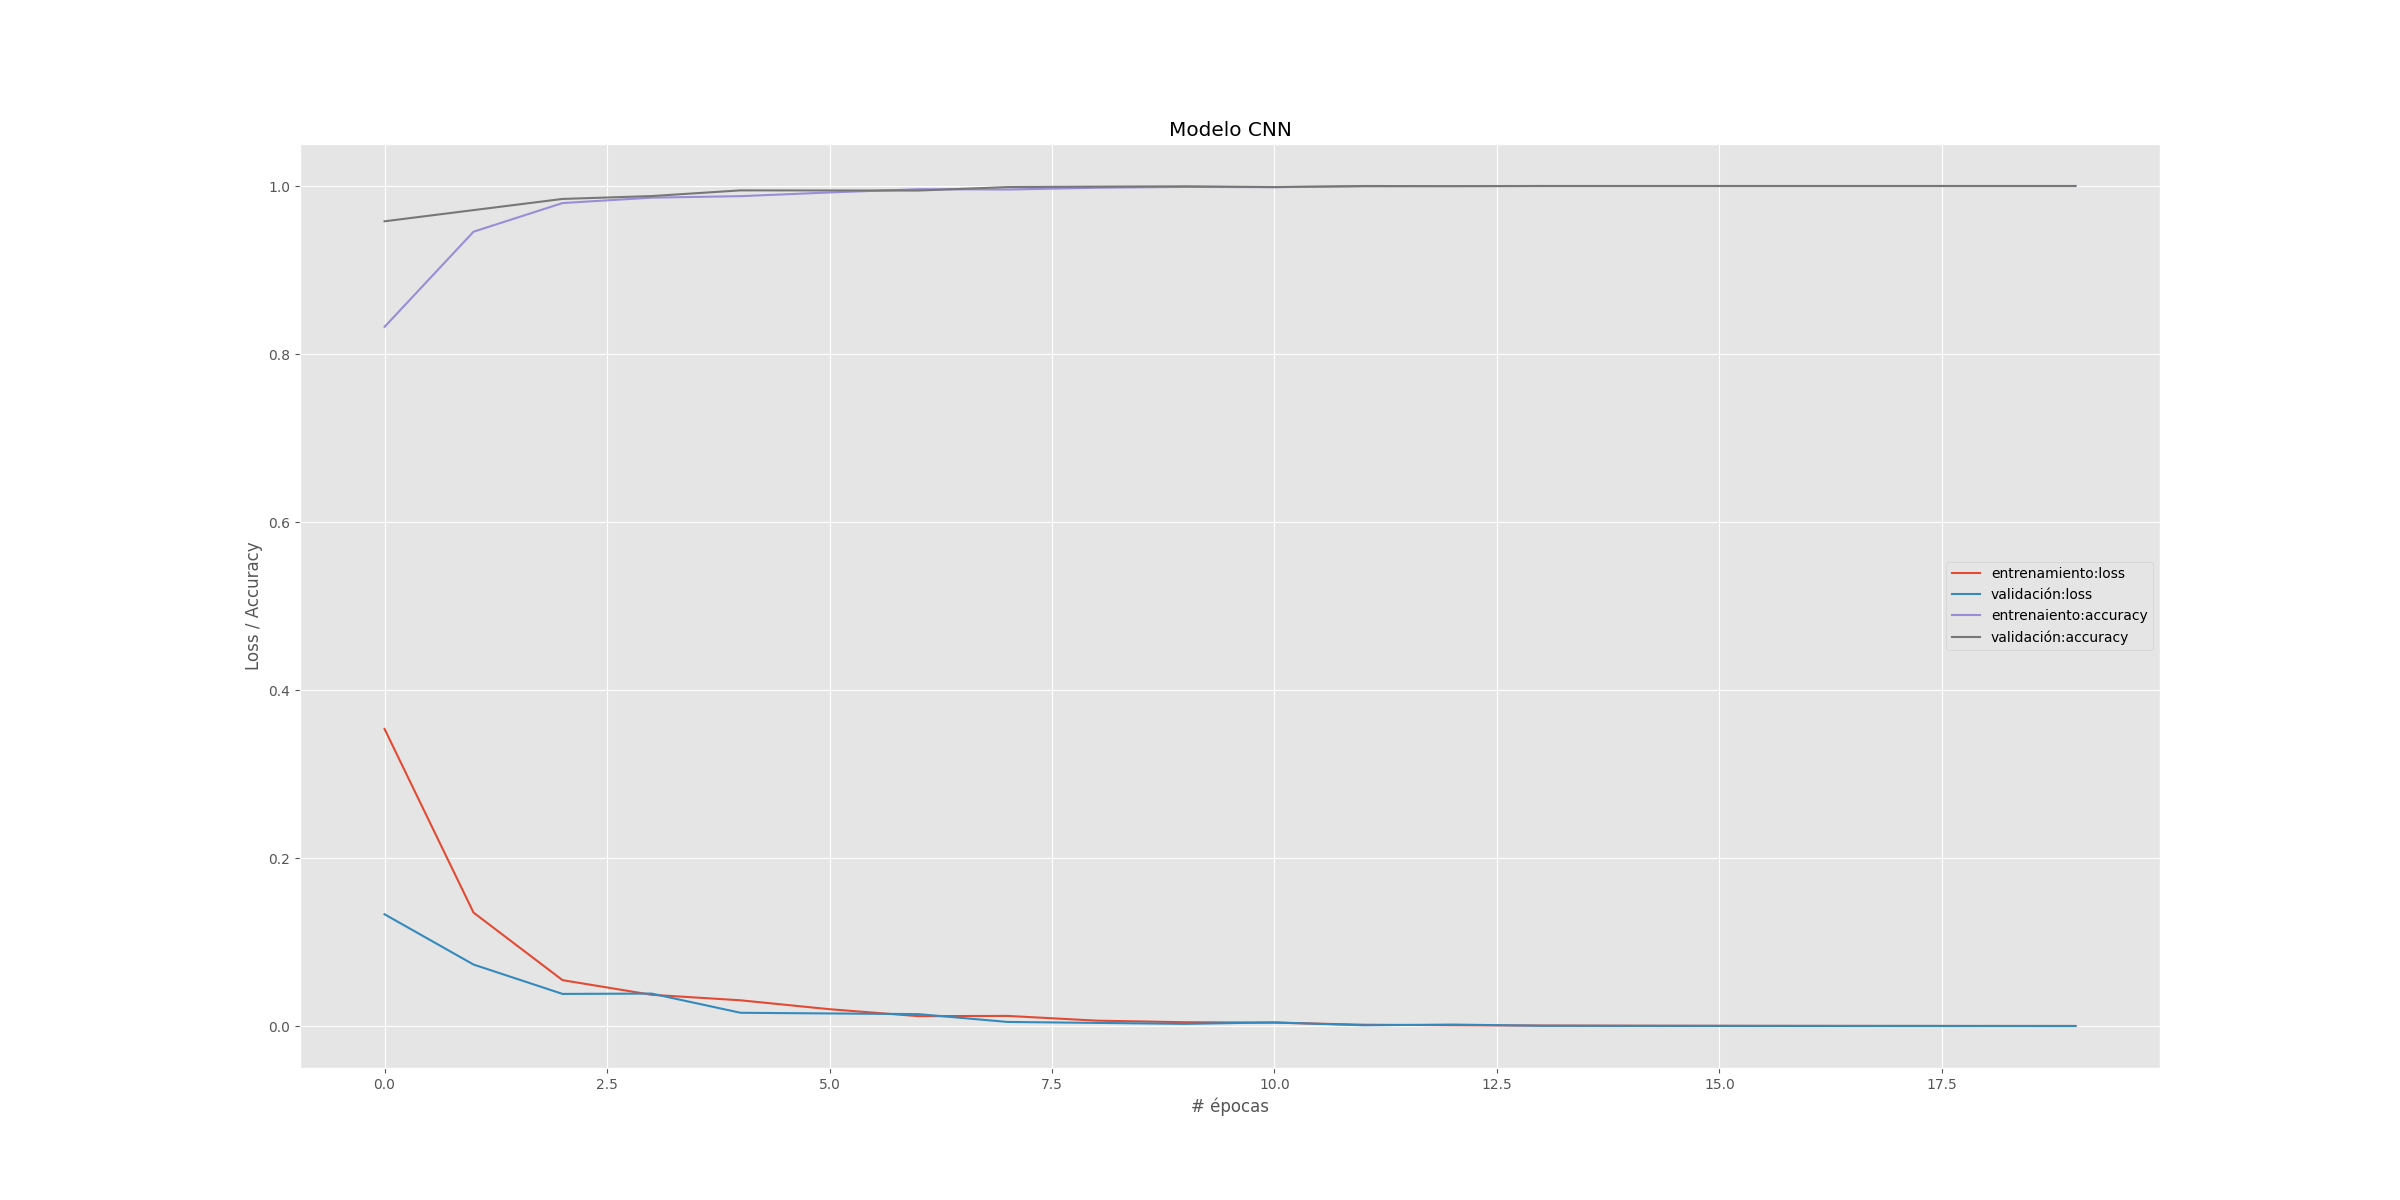


Luego de entrenar el modelo, se utilizaron 800 imágenes adicionales para validar el modelo. Esto se realiza en `CNN.validate()`.

```python
# cnn.py: CNN.validate()

  def validate(self, validation_dirs):
    print("[IN PROGRESS] Validating model")
    print("[IN PROGRESS] Loading dataset ")
    X_valid, labels = utils.load_dataset(validation_dirs,
                    [utils.resize(50,50), img_to_array],
                    verbose=1000
                  )
    X_valid = X_valid.astype( "float" )/255.0
    Y_valid = utils.binarize_labels(labels, self.classes)
    print("[DONE] Load dataset")

    print("[IN PROGRESS] Predicting ")
    predicciones = self.model.predict( X_valid )
    print("[DONE] Predict")

    print("[DONE] Validating model\n")

    print( classification_report(np.array(Y_valid).argmax(axis=1),
            predicciones.argmax(axis=1), target_names=self.classes)
    )
```

Los resultados fueron los siguientes. Casi todas las métricas se encuentran en 100%, lo que demuestra una buena predicción.

```
              precision    recall  f1-score   support

 WithoutMask       1.00      0.99      1.00       400
    WithMask       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800
```


### 5. Guardar el modelo
Luego del entrenamiento y validación, se guarda el modelo.

```python
self.model.save(model_exportfile)
```


### 6. Predicción en tiempo real
La detección en tiempo real ocurre en `detector.py` con el código brindado en clase modificado para detectar mascarillas.

Se carga el modelo del CNN que fue guardado en el paso anterior, se obtiene la porción de la imagen correspondiente a un rostro con `cv2.CascadeClassifier('dataset/haarcascade_frontalface_default.xml')` (el modelo para detección de rostros de OpenCV), se preprocesa la imagen y se se utiliza la función `predict` para obtener si es más probable que la imagen corresponda a un rostro con o sin máscara, colocando un rectángulo verde en el primer caso y uno rojo en el segundo caso.

```python
# detector.py. Modificaciones

GREEN = (0,255,0)
RED = (0,0,255)
class_colors = [RED, GREEN]
# 0 without mask, 1 with mask

model = load_model( 'out/mask_recog1.h5' )
preprocessors = [utils.resize(244,244), img_to_array, lambda img: img/255.0]

cap = cv2.VideoCapture(0)
classifier = cv2.CascadeClassifier('dataset/haarcascade_frontalface_default.xml')
while True:
    # ...

    for x,y,w,h in faces:
        # Preprocesar imagen antes de predecir
        face = frame[y:y+h, x:x+w]

        face = utils.preprocess_single(face, preprocessors)

        # Obtener la clase con mayor probabilidad
        predictions = model.predict(face)
        label=np.argmax( predictions, axis=1)[0]

        # Dibujar rectangulo
        cv2.rectangle(frame, (x,y), (x+w, y+h), class_colors[label], 2)
    cv2.imshow('frame', frame)
```